In [1]:
'''
The following implementation of an NLP Neural machine translation model is based on the Tensorflow tutorial available at:
https://www.tensorflow.org/text/tutorials/nmt_with_attention  (Itself based on Effective Approaches to Attention-based 
Neural Machine Translation (Luong et al., 2015))

The BLEU evaluation function is based on an implementation by Ben Trevett, available on his GitHub repo available at:
https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb

Both tutorials were accessed on 11/12/2022
'''

'\nThe following implementation of an NLP Neural machine translation model is based on the Tensorflow tutorial available at:\nhttps://www.tensorflow.org/text/tutorials/nmt_with_attention  (Itself based on Effective Approaches to Attention-based \nNeural Machine Translation (Luong et al., 2015))\n\nThe BLEU evaluation function is based on an implementation by Ben Trevett, available on his GitHub repo available at:\nhttps://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb\n\nBoth tutorials were accessed on 11/12/2022\n'

In [2]:
#!pip install "tensorflow-text>=2.10"
#!pip install einops
#!pip install matplotlib

In [3]:
import numpy as np
import typing
from typing import Any, Tuple
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow_text as tf_text


C:\Users\coryj\anaconda3\envs\tf_gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [5]:
sentence = []
context=[]
test_target = open('test-target.txt', 'r', encoding='utf8')
for line in test_target:
  token = line.rstrip("\n")
  if (token != '<s>') and (token != '</s>'):
    sentence.append(token)
  elif token == '</s>':
    context.append(sentence)
  elif (token == '<s>'):
    sentence=[]
context_raw=[' '.join(elements) for elements in context]
context_raw = np.array(context_raw)

In [6]:
sentence = []
target=[]
test_source = open('test-source.txt', 'r', encoding='utf8')
for line in test_source:
  token = line.rstrip("\n")
  if (token != '<s>') and (token != '</s>'):
    sentence.append(token)
  elif token == '</s>':
    target.append(sentence)
  elif (token == '<s>'):
    sentence=[]
target_raw=[' '.join(elements) for elements in target]
target_raw = np.array(target_raw)

In [7]:
print("Length of context_raw:", len(context_raw))
print("Length of target_raw:", len(target_raw))
print()
print("source",context_raw[-1])
print()
print("target",target_raw[-1])


Length of context_raw: 1000
Length of target_raw: 1000

source Bhí muid ag cuartú agus ag breathnú ní ba ghrinne anois agus fuair muid comharthaí agus iarsmaí go leor ar áitreabh na ndeartháireacha , ach sháraigh orainn a gcuid corp a fháil ná poll a bhféadfadh siad titim isteach ann .

target Bhíomar ag cuartughadh agus ag breath - nughadh ní ba ghrinne anois agus fuair muid comharthaí agus iarsmaí go leór ar áitreabhadh na ndearbhráithreach , ach sháruigh orainn a gcuid corp a fhagháil ná poll a bhféadfadh siad tuitim isteach ann .


In [8]:
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

In [9]:
is_train

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False, False,  True, False,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True, False, False, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,

In [10]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 8
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [11]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'N\xc3\xad fhaca an gas\xc3\xbar \xc3\xad , n\xc3\xb3 bh\xc3\xad taobh an bh\xc3\xa1id eadar \xc3\xa9 agus i f\xc3\xa9in , ach mhothaigh s\xc3\xa9 a han\xc3\xa1l agus an boladh a bh\xc3\xad aisti - boladh mar a bheadh as leathach ach go raibh s\xc3\xa9 i bhfad n\xc3\xad ba l\xc3\xa1idre ; agus is m\xc3\xb3r an t-iontas cad \xc3\xa9 mar a choinnigh s\xc3\xa9 \xc3\xa9 f\xc3\xa9in ar uachtar , ar mh\xc3\xa9ad is a bh\xc3\xad s\xc3\xa9 scanraithe .'
 b'Seomra m\xc3\xb3r cruinn a bh\xc3\xad ann gearrtha sa charraig agus \xc3\xa9 greagnaithe le clocha agus gairbh\xc3\xa9al .'
 b"' Cuirig\xc3\xad an diallait ar an Liath Mh\xc3\xb3r ! '"
 b"Ansin th\xc3\xa1inig n\xc3\xb3ta\xc3\xad cumh\xc3\xbala ' Vilikins and his Dinah ' chugam go fann ar an ghaoth ."
 b'Sc\xc3\xa9al Chathail Freeman - T\xc3\xa9ann mo dhearth\xc3\xa1ir chun na D\xc3\xbacharraige'], shape=(5,), dtype=string)

tf.Tensor(
[b"N\xc3\xad fhacaidh an gas\xc3\xbar \xc3\xad , na bh\xc3\xad taobh an bh\xc3\xa1id eadar \xc3

In [12]:
example_text = tf.constant('Bhí muid ag cuartú agus ag breathnú ní')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Bh\xc3\xad muid ag cuart\xc3\xba agus ag breathn\xc3\xba n\xc3\xad'
b'Bhi\xcc\x81 muid ag cuartu\xcc\x81 agus ag breathnu\xcc\x81 ni\xcc\x81'


In [13]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Bhí muid ag cuartú agus ag breathnú ní
[START] bhi muid ag cuartu agus ag breathnu ni [END]


In [15]:
max_vocab_size = 10000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [16]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', '.', 'an', ',', 'agus', 'ar']

In [17]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', '.', 'an', ',', 'agus', 'ar']

In [18]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[3, 23, 290, 6, 145, 16, 7, 25, 10, 111, 6, 377, 139, 22, 8, 16, 33, 7, 21,
  282, 15, 2, 1823, 8, 6, 1136, 2, 10, 1164, 1136, 39, 2, 77, 43, 1748, 21,
  14, 17, 15, 16, 187, 23, 37, 648, 8, 36, 74, 6, 1237, 91, 22, 39, 2, 369,
  15, 22, 33, 9, 331, 7, 9, 904, 36, 2, 10, 15, 602, 5, 4]                  ,
 [3, 485, 74, 706, 2, 10, 40, 1895, 30, 121, 8, 22, 1841, 20, 540, 8, 1928,
  5, 4]                                                                    ,
 [3, 1065, 6, 697, 9, 6, 643, 69, 141, 4]]>

In [19]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] ni fhaca an gasur i , no bhi taobh an bhaid eadar e agus i fein , ach mhothaigh se a hanal agus an boladh a bhi aisti boladh mar a bheadh as leathach ach go raibh se i bhfad ni ba laidre agus is mor an tiontas cad e mar a choinnigh se e fein ar uachtar , ar mhead is a bhi se scanraithe . [END]'

Text(0.5, 1.0, 'Mask')

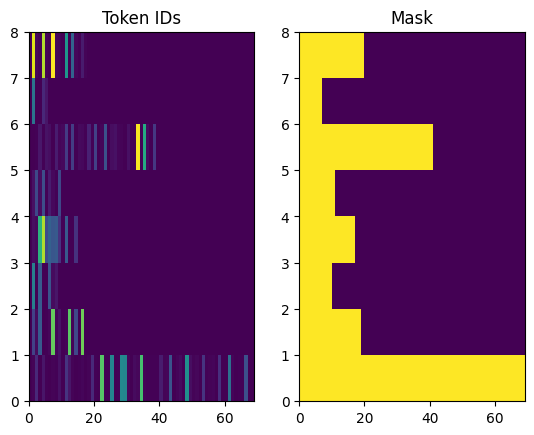

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [21]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [22]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[   3  276   15  874   69   76 1035    8  126   15]

[   3  267   15  871   89   71 1041    7    8  125]
[ 267   15  871   89   71 1041    7    8  125   15]


In [23]:
UNITS = 128

In [24]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [25]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (8, 49)
Encoder output, shape (batch, s, units): (8, 49, 128)


In [26]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [27]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (8, 49, 128)
Target sequence, shape (batch, t, units): (8, 48, 128)
Attention result, shape (batch, t, units): (8, 48, 128)
Attention weights, shape (batch, t, s):    (8, 48, 49)


In [28]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 0.9999999 , 1.        , 1.        ,
       0.99999994, 1.        , 0.9999999 , 1.        , 1.        ,
       0.9999999 , 1.        , 0.99999994, 1.        , 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994], dtype=float32)

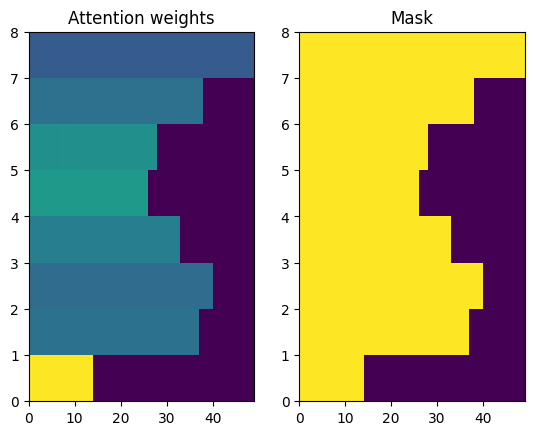

In [29]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [30]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [31]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [32]:
decoder = Decoder(target_text_processor, UNITS)

In [33]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (8, 49, 128)
input target tokens shape: (batch, t) (8, 48)
logits shape shape: (batch, target_vocabulary_size) (8, 48, 2736)


In [34]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [35]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [36]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'seirbhis baoghal talamh shaoil beacht fheabhas fhuinneoig caorach theora tchinn',
       b'fheiceail crathan bean ol samhailteacha scaoil phluchtach caide ndoimhneacht as',
       b'olta seisean laimh hinnleadh theoir si ceanntarnocht sibh chuige bhruid'],
      dtype=object)

In [38]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [39]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (8, 49)
Target tokens, shape: (batch, t) (8, 48)
logits, shape: (batch, t, target_vocabulary_size) (8, 48, 2736)


In [40]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [41]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [42]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [43]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 7.9142523, 'expected_acc': 0.0003654970760233918}

In [44]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 5s 30ms/step - loss: 7.9303 - masked_acc: 4.0899e-04 - masked_loss: 7.9303


{'loss': 7.930342674255371,
 'masked_acc': 0.00040898617589846253,
 'masked_loss': 7.930342197418213}

In [45]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
100/100 [==============================] - 9s 29ms/step - loss: 6.1629 - masked_acc: 0.0751 - masked_loss: 6.1619 - val_loss: 5.7585 - val_masked_acc: 0.1328 - val_masked_loss: 5.7585
Epoch 2/100
100/100 [==============================] - 3s 30ms/step - loss: 5.1130 - masked_acc: 0.1973 - masked_loss: 5.1126 - val_loss: 5.0971 - val_masked_acc: 0.2088 - val_masked_loss: 5.0971
Epoch 3/100
100/100 [==============================] - 3s 31ms/step - loss: 4.2593 - masked_acc: 0.2852 - masked_loss: 4.2593 - val_loss: 4.8280 - val_masked_acc: 0.2403 - val_masked_loss: 4.8280
Epoch 4/100
100/100 [==============================] - 3s 30ms/step - loss: 3.5138 - masked_acc: 0.3703 - masked_loss: 3.5135 - val_loss: 4.6414 - val_masked_acc: 0.2754 - val_masked_loss: 4.6414
Epoch 5/100
100/100 [==============================] - 3s 31ms/step - loss: 2.8790 - masked_acc: 0.4488 - masked_loss: 2.8793 - val_loss: 4.5982 - val_masked_acc: 0.2937 - val_masked_loss: 4.5982
Epoch 6/100
100/100 

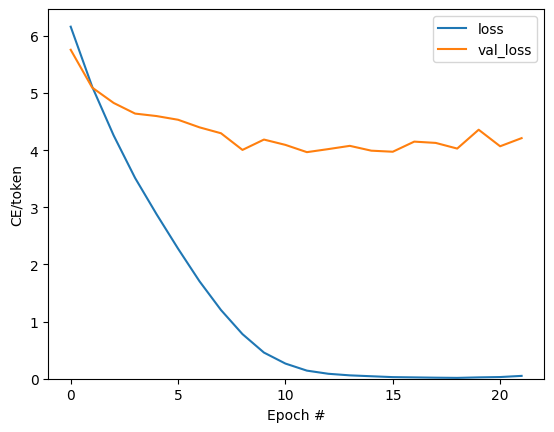

In [46]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

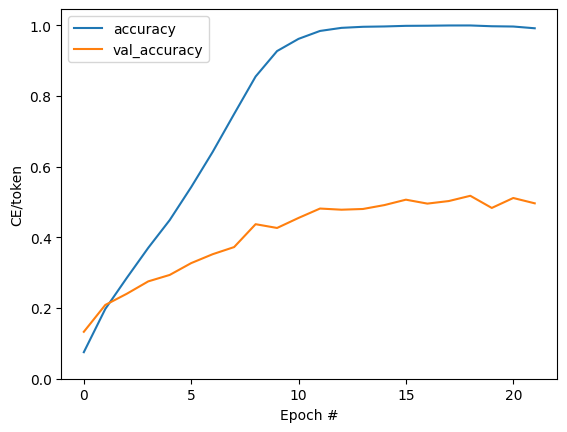

In [47]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [48]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [49]:
result = model.translate(['bhi muid ag cuartu agus ag breathnu ni ba ghrinne anois agus fuair'])
result[0].numpy().decode()

'bhi muid ag cuartughadh agus ag breath nughadh ni ba ghrinne anois agus fuair me uirthe ba chiall damh a fuair me do eaglais phrotastunach na heireann a fuair me . '

In [50]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

C:\Users\coryj\AppData\Local\Temp\ipykernel_13092\3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\coryj\AppData\Local\Temp\ipykernel_13092\3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


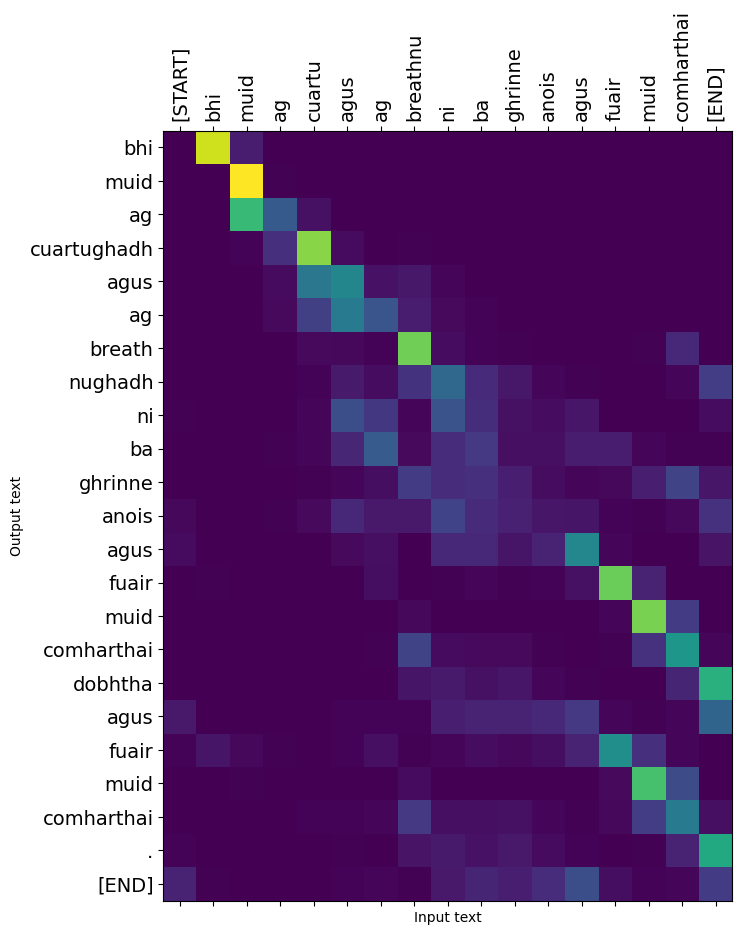

In [51]:
model.plot_attention('bhi muid ag cuartu agus ag breathnu ni ba ghrinne anois agus fuair muid comharthai') # Are you still home

In [52]:
# the raw data is sorted by length
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 Bhíomar ag cuartughadh agus ag breath - nughadh ní ba ghrinne anois
agus fuair muid comharthaí agus iarsmaí go leór ar áitreabhadh na
ndearbhráithreach , ach sháruigh orainn a gcuid corp a fhagháil ná
poll a bhféadfadh siad tuitim isteach ann .


C:\Users\coryj\AppData\Local\Temp\ipykernel_13092\3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\coryj\AppData\Local\Temp\ipykernel_13092\3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


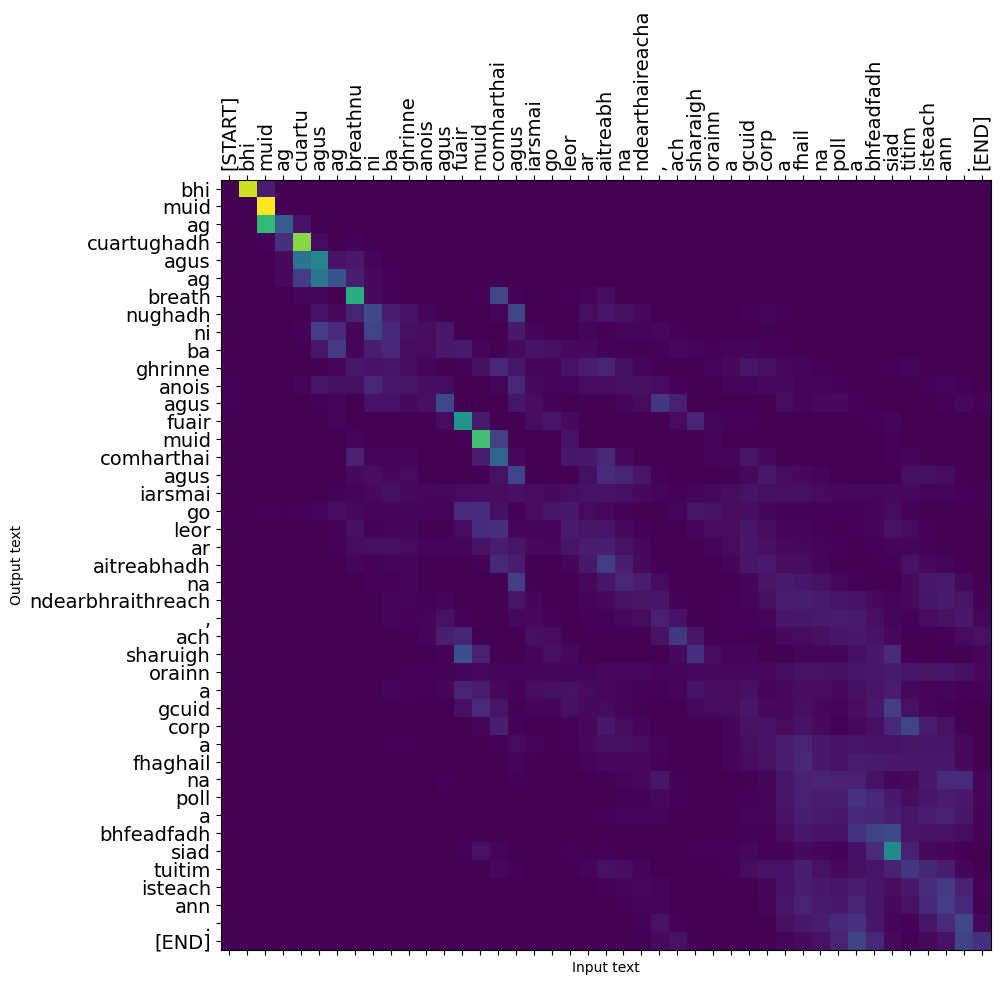

In [53]:
model.plot_attention(long_text)

In [54]:
# inputs=[] # can add inputs to list, process all at once
'''
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()
'''

'\nfor t in inputs:\n  print(model.translate([t])[0].numpy().decode())\n\nprint()\n'

In [55]:
sentence = []
context=[]
train_target = open('train-target.txt', 'r', encoding='utf8')
for line in train_target:
  token = line.rstrip("\n")
  if (token != '<s>') and (token != '</s>'):
    sentence.append(token)
  elif token == '</s>':
    context.append(sentence)
  elif (token == '<s>'):
    sentence=[]
target_source=[' '.join(elements) for elements in context]
target_source = np.array(target_source)

In [56]:
sentence = []
target=[]
train_target = open('train-target.txt', 'r', encoding='utf8')
for line in train_target:
  token = line.rstrip("\n")
  if (token != '<s>') and (token != '</s>'):
    sentence.append(token)
  elif token == '</s>':
    target.append(sentence)
  elif (token == '<s>'):
    sentence=[]
target_test=[' '.join(elements) for elements in target]
target_test = np.array(target_test)

In [57]:
from torchtext.data.metrics import bleu_score
import pandas as pd

def calculate_bleu(data, model):
    trgs = []
    pred_trgs = []
    for sequence in data:
        
        result = model.translate([sequence])
        result=result[0].numpy().decode()   
        
        pred_trgs.append(result)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

C:\Users\coryj\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:

bleu_score = calculate_bleu(train_ds, model)

print(f'BLEU  = {bleu_score*100:.2f}')

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [8,45] != values[1].shape = [8,46] [Op:Pack] name: 0